# Dynamic SSD with Focal Loss
Here I'll be trying out the RetinaNet implementation written by rohitgeo

# Imports  

In [1]:
from apex import amp
amp_handle = amp.init(enabled=True)
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from ssdoil import *
from ssd import *
from utils import *

In [2]:
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.vision import *

In [3]:
PATH = Path(r'./Bosch_trafficlight_data/')
JPEGS = 'train/CombinedAnnotatedJPEG'
IMG_PATH = PATH/JPEGS


In [4]:
def remove_string_from_name(images, string_to_remove='/home/m090009/dev/CarND-TrafficSignal/Bosch_trafficlight_data/train/JPEGImages/'):
    for i in range(len(images)):
        images[i] = images[i].split('/')[-1]
        if '.png' in images[i]:
            images[i] = images[i].replace('.png', '.jpg') 

## Copy annotated images

In [5]:
from sklearn.model_selection import train_test_split
images, lbl_bbox  = get_annotationss(PATH/'annotated_train.json')
remove_string_from_name(images)

train_images, val_images, train_lbl_bbox, val_lbl_bbox = train_test_split(images, lbl_bbox, test_size=0.20, random_state=42)

img2bbox = dict(zip(train_images, train_lbl_bbox))
img2bbox_v = dict(zip(val_images, val_lbl_bbox))
def get_y_func(x):
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes]

In [6]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        if not (bbs.nelement() == 0):
            bboxes[i,-len(lbls):] = bbs
            labels[i,-len(lbls):] = tensor(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [7]:
print("Total: {}, Train: {}, Val: {}".format(len(images), len(train_images), len(val_images)))


Total: 3153, Train: 2522, Val: 631


In [8]:
BS = 490

In [9]:
from ssdoil import SSDObjectItemList
%time
JPEGS = 'train/AnnotatedJPEG'
data = (SSDObjectItemList.from_folder(PATH/JPEGS)
        .split_by_files(val_images)                             
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=BS, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


CPU times: user 880 ms, sys: 996 ms, total: 1.88 s
Wall time: 34.2 s


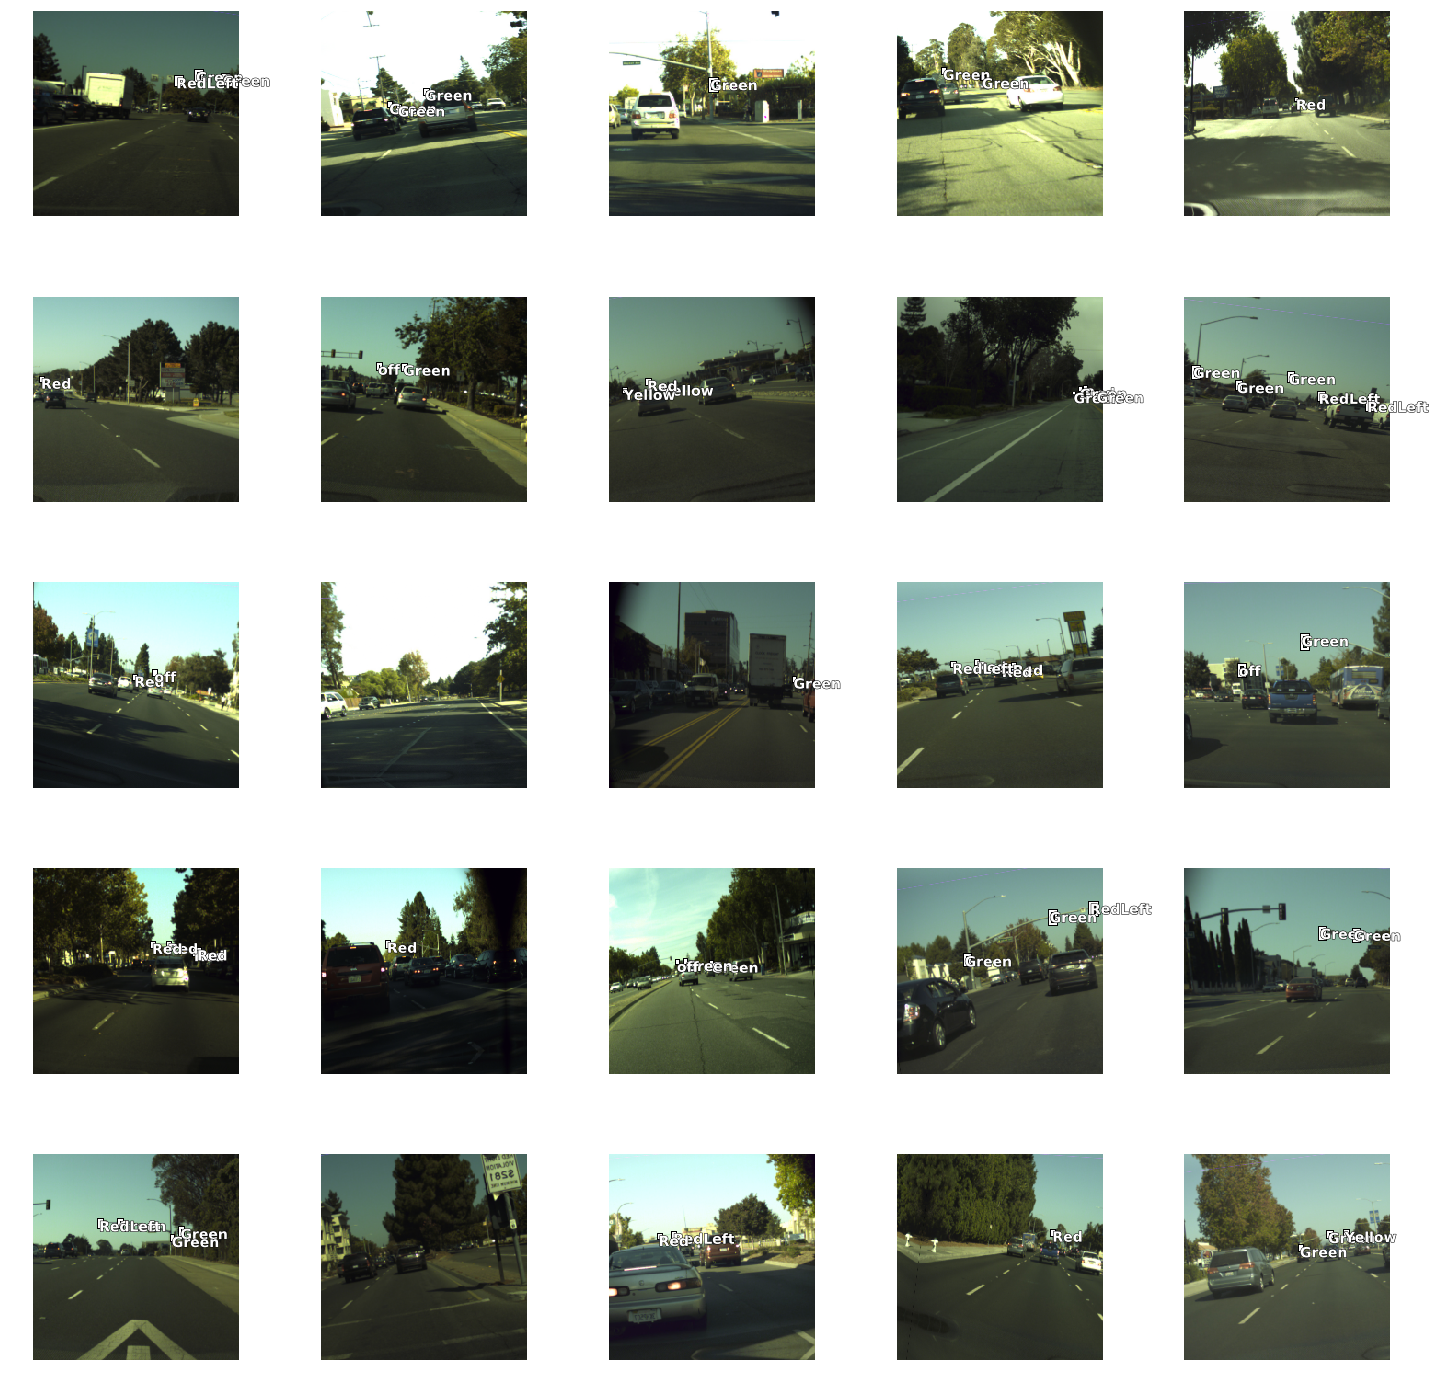

In [10]:
%%time
data.show_batch()

# Training

In [11]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [12]:
ssd_model = SingleShotDetector(data, focal_loss=True, pretrained_path='ssd-tl-FL-415')

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:93: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


## Export

In [13]:
ssd_model.learn.export()

In [15]:
learn = load_learner(PATH/'train/AnnotatedJPEG/')

AttributeError: 'ObjectCategoryProcessor' object has no attribute 'pad_idx'

## Predict

In [17]:
from torchvision.models import resnet34

In [ ]:
trn_tfms, val_tfms = tfms_from_model(resnet34,224) # get transformations
im = val_tfms(Image.open(PATH/'train/TESTJPEGS/test1.png'))
learn.precompute=False # We'll pass in a raw image, not activations
preds = learn.predict_array(im[None])
np.argmax(preds) # preds are log probabilities of classes

In [16]:
%debug

> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/data.py(330)process()
    328 
    329     def process(self, ds:ItemList):
--> 330         ds.pad_idx = self.pad_idx
    331         super().process(ds)
    332 

ipdb> p self
ipdb> p self.pad_idx
*** AttributeError: 'ObjectCategoryProcessor' object has no attribute 'pad_idx'
ipdb> u
> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py(74)process()
     72         if processor is not None: self.processor = processor
     73         self.processor = listify(self.processor)
---> 74         for p in self.processor: p.process(self)
     75         return self
     76 

ipdb> u
> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py(673)process()
    671     def process(self, xp:PreProcessor=None, yp:PreProcessor=None, name:str=None):
    672         "Launch the processing on `self.x` and `self.y` with `xp` and `yp`."
--> 673         self.y.process

ipdb> p model
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

ipdb> u
> <ipython-input-15-1a65330eba39>(1)<module>()
----> 1 learn = load_learner(PATH/'train/AnnotatedJPEG/')

ipdb> d
> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/basic_train.py(578)load_learner()
    576     state = torch.load(Path(path)/fname, map_location='cpu') if defaults.device == torch.device('cpu') else torch.load(Path(path)/fname)
    577     model = state.pop('model')
--> 578     src = LabelLists.load_state(path, state.pop('data'))
    579     if test is not None: src.add_test(test)
    580     data = src.databunch(**db_kwargs)

ipdb> p LabelLists
<class 'fastai.data_block.LabelLists'>
ipdb> d
> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py(553)load_state()
    551         "Create a `LabelLists` with empty sets from the serialized `state`."
    552         path = Path(path)
--> 553         train_ds = LabelList.load_state(path, state)
    554         valid_ds = LabelList.load_state(path, state)
    555     

In [28]:
ssd_model.fit(15, lr=lrs)

Gradient overflow, skipping update


## Save the Model

In [29]:
ssd_model.save('ssd-tl-FL-340')

## Stage 2

In [30]:
ssd_model.learn.freeze_to(-1)
lrs = np.array([max_lr/100, max_lr/10, max_lr])
ssd_model.fit(15, lrs/2)

## Stage 3

In [31]:
ssd_model.learn.freeze_to(-2)
ssd_model.learn.fit(15, lrs/2)

## Stage 4

In [32]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(15, lrs/4)

## Stage 5

In [33]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(15, lrs/5)

## Stage 6

In [34]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(15, lrs/5)

In [35]:
ssd_model.save('ssd-tl-FL-415')

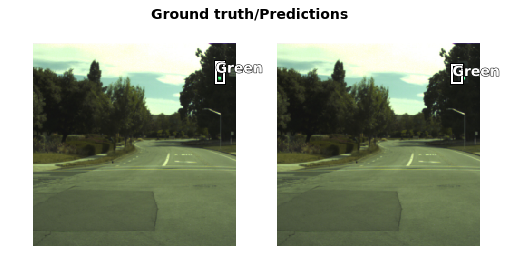

In [42]:
ssd_model.show_results(rows=1, thresh=0.28)

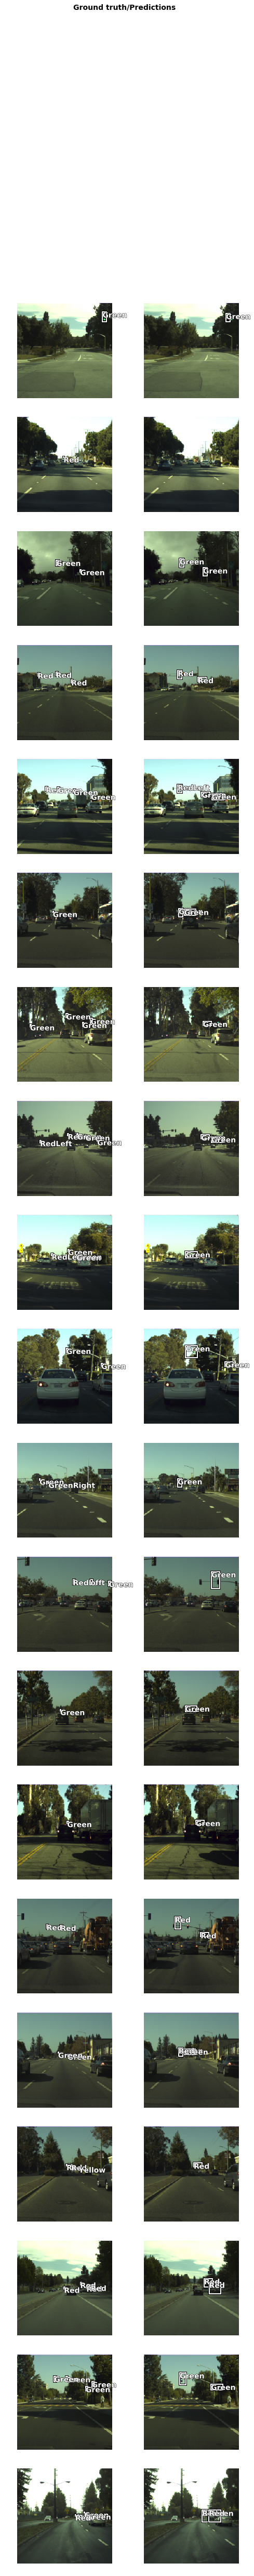

In [36]:
ssd_model.show_results(rows=20, thresh=0.3)

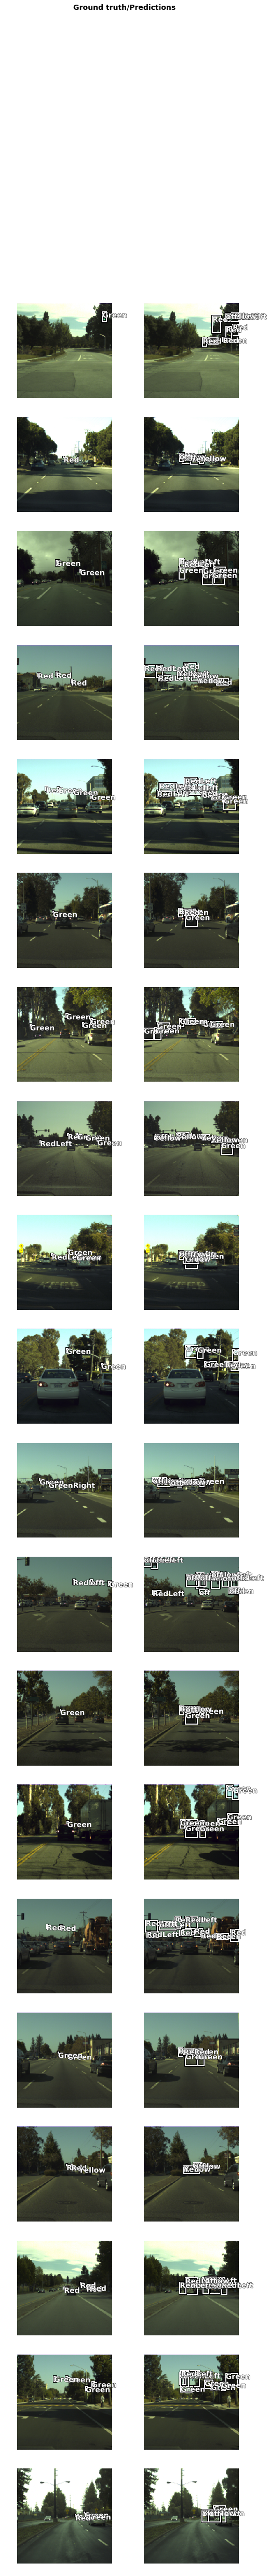

In [37]:
ssd_model.show_results(rows=20, thresh=0.1)

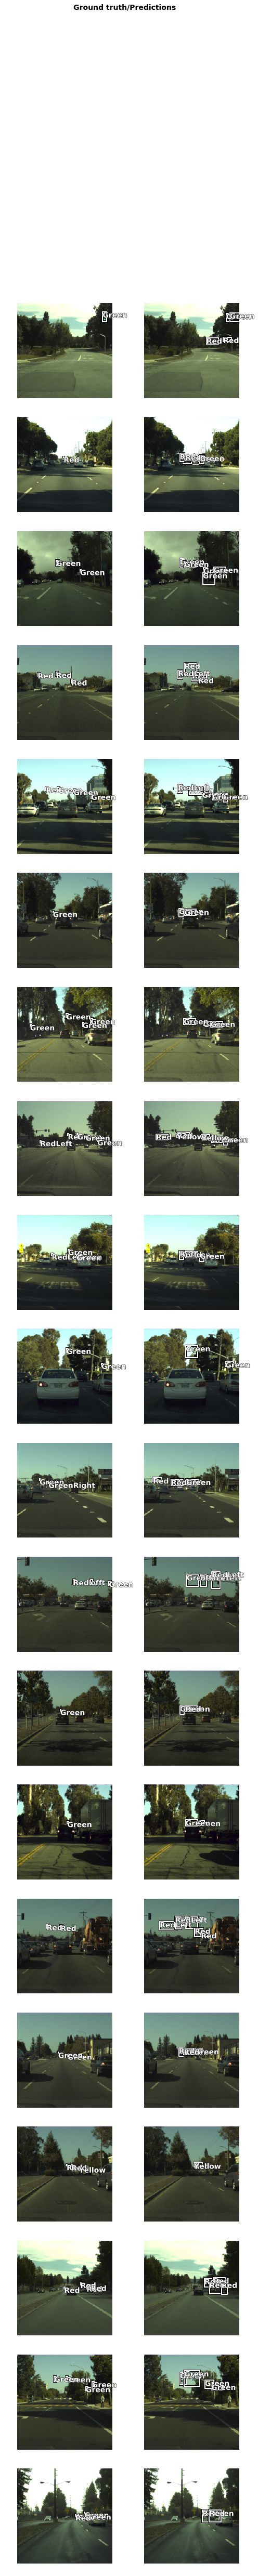

In [38]:
ssd_model.show_results(rows=20, thresh=0.2)

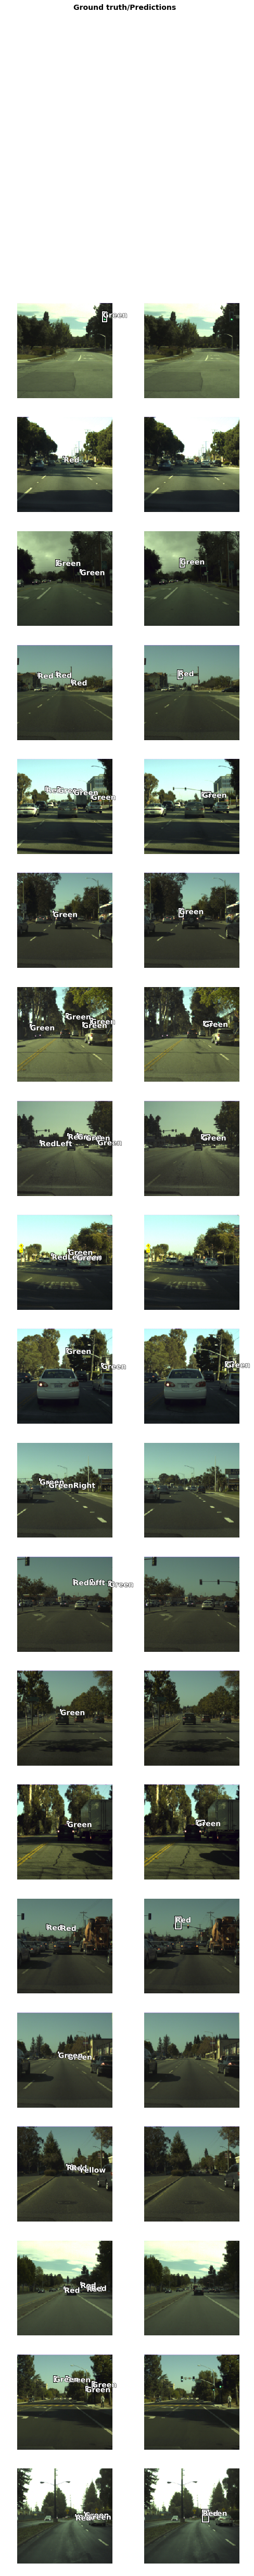

In [39]:
ssd_model.show_results(rows=20, thresh=0.4)

In [22]:
ssd_model.save('ssd-pascal-FL-20')

In [83]:
trn_tfms, val_tfms = tfms_from_model(resnet34, 224)
im = val_tfms(Image.open(PATH/'train/test1.jpg'))
ssd_model.learn.precompute = False
preds = ssd_model_array(im[None])
# np.argmax(preds)

NameError: name 'tfms_from_model' is not defined

## Show some results 

# Improve the result using feature pyramid